In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from itertools import combinations

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
RGMA_DIR = Path('/neelin2020/RGMA_feature_mask/data_product/2017/MERGED_FP')

In [4]:
# add post-defined deep convection and congestus
files = sorted(list(RGMA_DIR.glob('*_convmask.nc')))
data_PID = xr.open_mfdataset(files)
data_dc_mask = data_PID.deep_conv_mask
data_cg_mask = data_PID.nondeep_conv_mask

files_gpm = sorted(list(RGMA_DIR.glob('*_expand.nc')))
data_gpm = xr.open_mfdataset(files_gpm)
data_pcp = data_gpm.precipitationCal

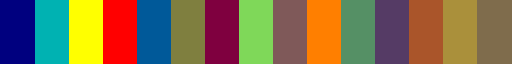

In [5]:
cmap_label = plt.get_cmap('tab20b', 10)
FID_colors = cmap_label(np.linspace(0, 1, 15))

FID_colors[0, :] = np.array([0, 0, 0.5, 1]) # AR
FID_colors[1, :] = np.array([0, 0.7, 0.7, 1]) # Front
FID_colors[2, :] = np.array([1, 1, 0, 1]) # MCS
FID_colors[3, :] = np.array([1, 0, 0, 1]) # LPS

FID_colors[4, :] = (FID_colors[0, :] + FID_colors[1, :])/2 # AF
FID_colors[5, :] = (FID_colors[0, :] + FID_colors[2, :])/2 # AM
FID_colors[6, :] = (FID_colors[0, :] + FID_colors[3, :])/2  # AL
FID_colors[7, :] = (FID_colors[1, :] + FID_colors[2, :])/2  # FM
FID_colors[8, :] = (FID_colors[1, :] + FID_colors[3, :])/2  # FL
FID_colors[9, :] = (FID_colors[2, :] + FID_colors[3, :])/2  # ML

FID_colors[10, :] = (FID_colors[0, :] + FID_colors[1, :] + FID_colors[2, :])/3 # AFM
FID_colors[11, :] = (FID_colors[0, :] + FID_colors[1, :] + FID_colors[3, :])/3 # AFL
FID_colors[12, :] = (FID_colors[0, :] + FID_colors[2, :] + FID_colors[3, :])/3  # AML
FID_colors[13, :] = (FID_colors[1, :] + FID_colors[2, :] + FID_colors[3, :])/3  # FML
FID_colors[14, :] = (FID_colors[0, :] + FID_colors[1, :] + FID_colors[2, :] + FID_colors[3, :])/4  # All

FID_cmp = ListedColormap(FID_colors)

# for hatch line color: # M, L, A, F
FID_hatch_color = FID_colors[[2,3,0,1],:] 
# base color: AF, AF, ML, ML
FID_base_color = FID_colors[[4,4,9,9],:] 

FID_label = ['AR','FT','MCS','LPS','AF','AM','AL','FM','FL','ML','AFM','AFL','AML','FML','All','UE']
FID_cmp

(0.0, 60.0)

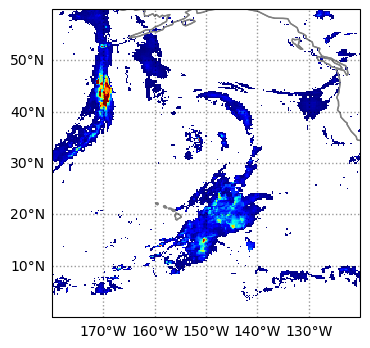

In [27]:
# plot GPM rainfall

fig, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(color='gray')
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND

# GPM rainrate threshold: 0.1 (mm/hr) removing drizzles for clarity 
tmp_pcp = data_pcp.isel(time=0)
# set rainfall thershold
tmp_pcp = tmp_pcp.where(tmp_pcp > 0.1, np.nan)

cf = ax.pcolormesh(tmp_pcp.longitude, tmp_pcp.latitude, tmp_pcp, cmap='jet',
                   vmin=0.1, vmax=20)
#plt.colorbar(cf, ax=ax, shrink=0.6)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#ax.set_title(str(tmp.time.values)[:13] + ', PID', fontsize=11)
ax.set_xlim([-180,-120])
ax.set_ylim([0,60])

In [28]:
tmp_pcp.time

<xarray.DataArray 'time' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-01-01

(0.0, 60.0)

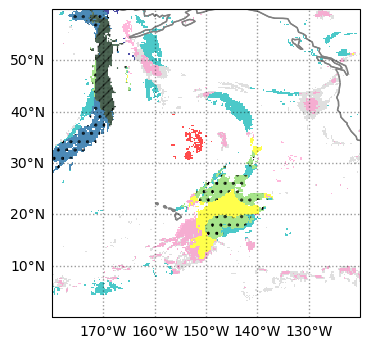

In [26]:
# set colorset and hatch

fig, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(color='gray')
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND

# GPM rainrate threshold: 0.1 (mm/hr) removing drizzles for clarity 
tmp = data_PID['feat_comb_label'].isel(time=0)
tmp_pcp = data_pcp.isel(time=0).sel(longitude=tmp.longitude)

tmp = tmp.where(tmp > 0, np.nan)
# set rainfall thershold
tmp = tmp.where(tmp_pcp > 0.1, np.nan)

# plotting 4 individual features 
for pid in [1,2,3,4]:
    
    tmp2 = tmp.where(tmp == pid, np.nan)
 
    cf = ax.pcolormesh(data_PID.longitude, data_PID.latitude
                 , tmp2, cmap=ListedColormap(FID_colors[pid-1,:]), alpha=0.7)
    
# the combinations of any two features
for pid in [5,6,7,8,9,10]:
    tmp2 = tmp.where(tmp == pid, np.nan)
    z_masked = np.ma.masked_less(tmp2, pid)
 
    cf = ax.pcolormesh(data_PID.longitude, data_PID.latitude
                 , tmp2, cmap=ListedColormap(FID_colors[pid-1,:]), alpha=0.7)
    none_map = ListedColormap(['none'])
    ax.pcolor(tmp2.longitude, tmp2.latitude, z_masked, cmap=none_map,
          hatch='..', edgecolor='k', lw=0, zorder=2)

# plotting hatch for overlapping by three features
for pid in [11,12,13,14,15]:
    tmp2 = tmp.where(tmp == pid, np.nan)
    z_masked = np.ma.masked_less(tmp2, pid)
 
    cf = ax.pcolormesh(data_PID.longitude, data_PID.latitude
                 , tmp2, cmap=ListedColormap(FID_colors[pid-1,:]), alpha=0.7)
    
    none_map = ListedColormap(['none'])
    ax.pcolor(tmp2.longitude, tmp2.latitude, z_masked, cmap=none_map,
          hatch='///', edgecolor='k', lw=0, zorder=2, alpha=0.5, linewidth=1)
    
# plotting unexplained
tmp2 = tmp.where(tmp == 16, np.nan)
grey = np.array([224/256, 224/256, 224/256, 1])
cf = ax.pcolormesh(tmp2.longitude, tmp2.latitude, tmp2, cmap=ListedColormap(grey))

#plotting post-defined DC and CG
tmp2 = (data_dc_mask + data_cg_mask).isel(time=0)
tmp2 = tmp2.where(tmp2 >= 1, np.nan)
magenta = np.array([255/255, 153/255, 204/255, 1])
cf = ax.pcolormesh(tmp2.longitude, tmp2.latitude, tmp2, cmap=ListedColormap(magenta), alpha=0.7)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#ax.set_title(str(tmp.time.values)[:13] + ', PID', fontsize=11)
ax.set_xlim([-180,-120])
ax.set_ylim([0,60])

(20.0, 60.0)

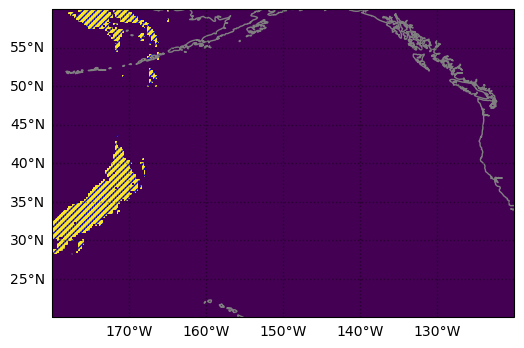

In [100]:
fig, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(color='gray')
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND

tmp2 = tmp.where(tmp == 5, 0)

lat_min = tmp2.latitude[0]
lat_max = tmp2.latitude[-1]
lon_min = tmp2.longitude[0]
lon_max = tmp2.longitude[-1]
#hatch = ax.fill_between([lon_min,lon_max],lat_min,lat_max, hatch='/////',color='none',edgecolor='black')
z_masked = np.ma.masked_less(tmp2, 5)
ax.pcolormesh(tmp2.longitude, tmp2.latitude, tmp2)
none_map = ListedColormap(['none'])
ax.pcolor(tmp2.longitude, tmp2.latitude, z_masked, cmap=none_map,
          hatch='/////', edgecolor=FID_colors[0, :], lw=0)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_xlim([-180,-120])
ax.set_ylim([20,60])

(20.0, 60.0)

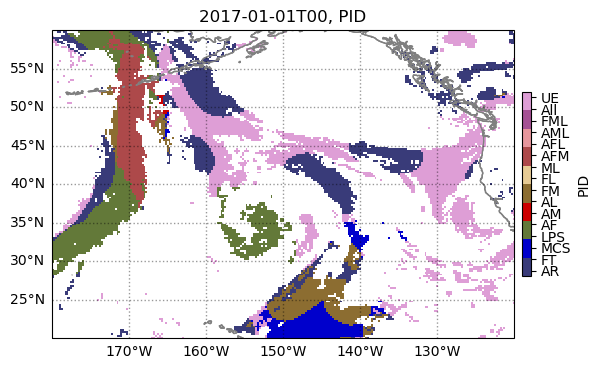

In [77]:
fig, ax = plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines(color='gray')
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='gray',facecolor='w') # maskout LAND

tmp = data_PID['feat_comb_label'].isel(time=0)
tmp = tmp.where(tmp > 0, np.nan)

cf = ax.pcolormesh(data_PID.longitude, data_PID.latitude
                 , tmp, vmin=0.5, vmax=16.5, cmap=newcmp)
cbar = plt.colorbar(cf, ax=ax, shrink=0.6, pad=0.01)
cbar.set_label('PID')
cbar.set_ticks(np.arange(1,17))
cbar.set_ticklabels(FID_label)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title(str(tmp.time.values)[:13] + ', PID')
ax.set_xlim([-180,-120])
ax.set_ylim([20,60])